In [1]:
from __future__ import print_function

# ignore some Keras warnings regarding deprecations and model saving 
import warnings
warnings.filterwarnings('ignore')

from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense
import pickle, numpy as np
from random import Random


Using TensorFlow backend.


In [2]:
batch_size = 64  # Batch size for training.
epochs = 2  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples =5000 # Number of samples to train on.
# Path to the datatxt file on disk.
data_path = 'fra.txt'


In [3]:
def read_data(fname, delimiter="\n"):
    """Helper reading a file with the input and 
    target texts.
    Returns a tuple with 2 lists of phrases (input, target)"""
    input_phrases = []
    target_phrases = []
    with open(fname, 'r', encoding='utf-8') as f:
        lines = f.read().split(delimiter)
    
        for line in lines:
            pair = line.split('\t')
            if len(pair) !=2: continue 

            input_text, target_text = pair
            input_phrases.append(input_text)
            target_phrases.append(target_text)

        return (input_phrases, target_phrases)

In [4]:
def wrap_with_delims(texts, start='\t', end='\n'):
    """Helper wrapping the input texts with the start
    and and end sequence delimiters.""" 
    return [start + t + end for t in texts]

def text_preprocess(texts):
    """Some minimal text preprocessing:
    * downcase
    * remove trailing periods
    * remove a weird unicode char"""
    return [t.strip().lower().\
            rstrip('.').strip().\
            replace(u'\u202f', '').\
            replace(u'\ufeff','') for t in texts]

In [5]:
all_input_phrases, all_target_phrases = read_data(data_path)
all_input_phrases = text_preprocess(all_input_phrases)
all_target_phrases = text_preprocess(all_target_phrases)
all_target_phrases = wrap_with_delims(all_target_phrases)

# keep only `num_samples` examples. 
# Note: we're starting from the 2nd example, its not important
input_phrases, target_phrases = all_input_phrases[1:num_samples+1], all_target_phrases[1:num_samples+1]
# Wrap the target phrases with delimiters signifying the start end end of the sequence

print("Training on %d selected phrases" % len(input_phrases))

Training on 5000 selected phrases


In [6]:
list(zip(input_phrases[:5], target_phrases[:5]))

[('run!', '\tcours!\n'),
 ('run!', '\tcourez!\n'),
 ('wow!', '\tça alors!\n'),
 ('fire!', '\tau feu !\n'),
 ('help!', "\tà l'aide!\n")]

In [7]:
# a dict of the index of each token
def token_index(texts):
    """Create a dictionary with all characters in the `texts` corpus
    and a number signifying their index in an 1-hot encoding."""
    vocab = set()
    for txt in texts:
        for char in txt: vocab.add(char)
    vocab = sorted(list(vocab))
    return dict([(char, i) for i, char in enumerate(vocab)])
print(token_index(['abc', 'cde!']))

{'!': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5}


In [8]:
# build the token index on all available phrases
input_token_index = token_index(all_input_phrases)
target_token_index = token_index(all_target_phrases)
num_encoder_tokens = len(input_token_index)
num_decoder_tokens = len(target_token_index)
max_encoder_seq_length = max([len(txt) for txt in input_phrases])
max_decoder_seq_length = max([len(txt) for txt in target_phrases])
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of unique input tokens: 63
Number of unique output tokens: 83
Max sequence length for inputs: 14
Max sequence length for outputs: 58


In [14]:
def vectorize_batch(texts, token_index, max_seq_len, offset=False):
    num_tokens = len(token_index)
    example_count =len(texts)
    
    # Generate 1-hot encoding
    data = np.zeros((example_count, max_seq_len, num_tokens),dtype='float32')
    
    for i, text in enumerate(texts):
        start_t = 1 if offset else 0
        for t, char in enumerate(text[start_t:]):
            idx = token_index[char]
            data[i, t, idx] = 1.
    return data

def vectorize_dataset(input_texts, target_texts,
                      input_token_index, target_token_index,
                      max_encoder_seq_length, max_decoder_seq_length):
    return ([vectorize_batch(input_texts, input_token_index,
                             max_encoder_seq_length),
             vectorize_batch(target_texts, target_token_index,
                             max_decoder_seq_length)],
            # same as decoder input data, but offset by one
            vectorize_batch(target_texts, target_token_index,
                            max_decoder_seq_length, True))

def vectorizer(inp, targ):
    """A closure that encapsulates the information about the token indices and
    the sequence lengths"""
    return vectorize_dataset(inp, targ, input_token_index,
                             target_token_index,
                             max_encoder_seq_length, 
                             max_decoder_seq_length)

In [15]:
def models(num_encoder_tokens, num_decoder_tokens, latent_dim):
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None, num_encoder_tokens), name='encoder_inputs')
    encoder = LSTM(latent_dim, return_state=True, name='encoder')
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = Input(shape=(None, num_decoder_tokens), name='decoder_inputs')
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, 
                        name='decoder_lstm')
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                         initial_state=encoder_states)
    decoder_dense = Dense(num_decoder_tokens, activation='softmax', 
                          name='decoder_dense')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Next: inference mode (sampling).
    # Here's the drill:
    # 1) encode input and retrieve initial decoder state
    # 2) run one step of decoder with this initial state
    # and a "start of sequence" token as target.
    # Output will be the next target token
    # 3) Repeat with the current target token and current states

    # Define sampling models
    encoder_model = Model(encoder_inputs, encoder_states)

    decoder_state_input_h = Input(shape=(latent_dim,), name='decoder_input_h')
    decoder_state_input_c = Input(shape=(latent_dim,), name='decoder_input_c')
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return model, encoder_model, decoder_model


In [16]:
model, encoder_model, decoder_model = models(num_encoder_tokens, num_decoder_tokens, latent_dim)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [17]:
#X = [encoder_input_data, decoder_input_data]
#Y = decoder_target_data
X, Y = vectorizer(input_phrases, target_phrases)
history = model.fit(X,Y,
                   batch_size=batch_size, epochs=epochs, 
                   validation_split=0.1)

Train on 4500 samples, validate on 500 samples
Epoch 1/2
4500/4500 [==============================] - 28s 6ms/step - loss: 0.8842 - val_loss: 0.9229
Epoch 2/2
4500/4500 [==============================] - 31s 7ms/step - loss: 0.7886 - val_loss: 0.7996


In [33]:
import matplotlib.pyplot as plt
def plot_history(history):
    """credit: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

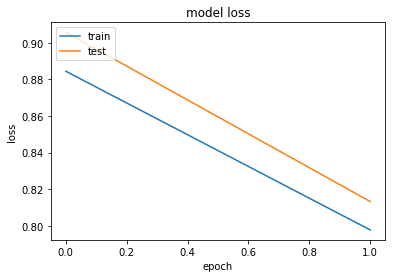

In [34]:
plot_history(history)

In [35]:
test_input_phrases = all_input_phrases[num_samples:num_samples+1000]
test_target_phrases = all_target_phrases[num_samples:num_samples+1000]

X, Y = vectorizer(test_input_phrases, test_target_phrases)

In [36]:

model.evaluate([encoder_input_data, decoder_input_data], decoder_target_data) 

5000/5000 [==============================] - 12s 2ms/step


0.7571103242874145

In [ ]:
model.save('training.h5')
encoder_model.save('encoder.h5')
decoder_model.save('decoder.h5')

model_metadata = { 'input_token_index': input_token_index, 
                   'target_token_index': target_token_index,
                   'max_encoder_seq_length': max_encoder_seq_length }

with open('model_metadata.pickle', 'wb') as f:
    pickle.dump(model_metadata, f)

In [ ]:
model = load_model('training.h5')
encoder_model = load_model('encoder.h5')
decoder_model = load_model('decoder.h5')

with open('model_metadata.pickle', 'rb') as f:
    model_metadata = pickle.load(f)

input_token_index = model_metadata['input_token_index']
target_token_index = model_metadata['target_token_index']
max_encoder_seq_length = model_metadata['max_encoder_seq_length']

In [15]:
model.evaluate([encoder_input_data, decoder_input_data], 
                   decoder_target_data,)

 17376/280000 [>.............................] - ETA: 9:44

KeyboardInterrupt: 

In [13]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = {v: k for k, v in input_token_index.items()}
reverse_target_char_index = {v: k for k, v in target_token_index.items()} 

In [16]:
[l.name for l in decoder_model.layers]

['decoder_inputs',
 'decoder_input_h',
 'decoder_input_c',
 'decoder_lstm',
 'decoder_dense']

In [17]:
input_phrases[:25]

['run!',
 'run!',
 'wow!',
 'fire!',
 'help!',
 'jump',
 'stop!',
 'stop!',
 'stop!',
 'wait!',
 'wait!',
 'i see',
 'i try',
 'i won!',
 'i won!',
 'oh no!',
 'attack!',
 'attack!',
 'cheers!',
 'cheers!',
 'cheers!',
 'cheers!',
 'get up',
 'got it!',
 'got it!']

In [18]:
def translate(phrase, encoder_model, decoder_model, 
              input_token_index, target_token_index):
    vect = vectorize_phrase(phrase, input_token_index,
                            max_encoder_seq_length)
    decoded = decode_sequence(vect,target_token_index, 
                        encoder_model, decoder_model)
    return decoded[:-1]

translator = lambda p: translate(p, encoder_model, decoder_model,
                                input_token_index, target_token_index)

In [19]:
# find max encoder seq legth
#max_encoder_seq_length = encoder_model.get_layer('encoder_inputs').input_shape[-1]
phrases = ['fire', 'stp', 'comein', 'get ot', 'i cant go',
          'im sorry', 'h is busi', 'hes drunk']

[translator(phrase) for phrase in phrases]

['fire out',
 'stop',
 'come in',
 'get out',
 'i can go',
 "i'm sor",
 'he is busy',
 "he's drunk"]

In [28]:
test_phrases = input_phrases[20:1020]
misspelled_test_phrases = [add_noise_to_string(p, .1) for p in test_phrases]

pairs = zip(misspelled_test_phrases, test_phrases)
errors = list(filter(lambda p: translator(p[0]) != p[1], pairs))
len(errors)/float(len(test_phrases))

0.232

In [12]:
input_phrases, _ = read_data(data_path)
input_phrases = text_preprocess(input_phrases)

encoder_vectorizer = lambda b: vectorize_batch(b, input_token_index,
                                               max_encoder_seq_length)
decoder_vectorizer = lambda b, offset: vectorize_batch(b, target_token_index,
                                                       max_decoder_seq_length, offset) 

def vectorized_gen(phrases, batch_size,encoder_vectorizer, decoder_vectorizer):
    for i in range(0, len(phrases), batch_size):
        input_phrases, target_phrases =  misspelling_gen(phrases[i:i+batch_size], 0.07, 3)
        print(len(input_phrases))
        print(len(target_phrases))
        encoder_input_data = encoder_vectorizer(input_phrases)
        decoder_input_data = decoder_vectorizer(target_phrases, False)
        decoder_target_data = decoder_vectorizer(target_phrases, True)
        max_encoder_seq_length = max([len(txt) for txt in input_phrases])
        
        yield ([encoder_input_data, decoder_input_data], decoder_target_data)
        print('yielded')

training_generator = vectorized_gen(input_phrases, num_samples, encoder_vectorizer, decoder_vectorizer)


In [14]:
input_token_index = token_index(input_phrases)
target_token_index = token_index(target_phrases)
num_encoder_tokens = len(input_token_index)
num_decoder_tokens = len(target_token_index)
max_encoder_seq_length = max([len(txt) for txt in input_phrases])
max_decoder_seq_length = max([len(txt) for txt in target_phrases])

In [15]:
for _ in range(5):
    spell_gen = lambda : misspelling_gen(input_phrases, 0.07, 3)
    X, Y = next(training_generator)
    model.fit(X, Y,
          batch_size=batch_size,
          epochs=5,
          validation_split=0.1)


240000
240000


MemoryError: 